Dataset Shape: (50000, 2)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



Applying Data Augmentation...
Augmented Dataset Shape: (100000, 3)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Tokenizing Data...

Building Model...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  591361    
 ificationHead)                                                  
                                                                 
Total params: 124646401 (475.49 MB)
Trainable params: 124646401 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Starting Training...
Epoch 1/3
2250/2250 [==============================] - 1983s 873ms/step - loss: 0.2889 - accuracy: 0.8696 - val_loss: 0.2408 - val_accuracy: 0.9050
Epoch 2/3
2250/2250 [==============================] - 1970s 876ms/step - lo

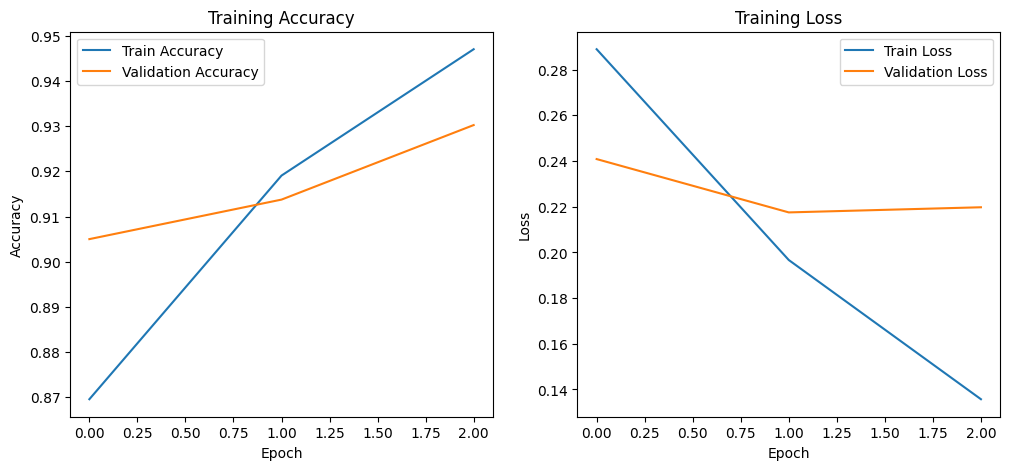


Evaluating Model...
625/625 [==============================] - 171s 271ms/step
Accuracy: 0.9272
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92      9960
           1       0.90      0.96      0.93     10040

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

ROC AUC: 0.9799348189571032


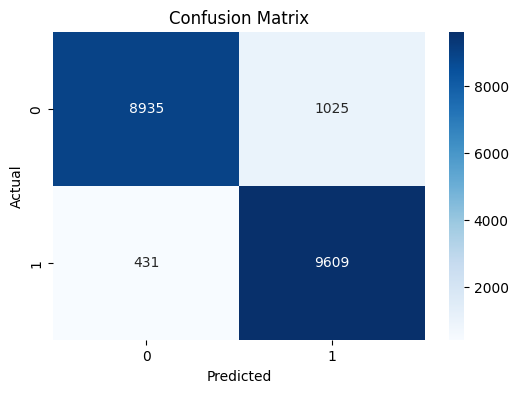

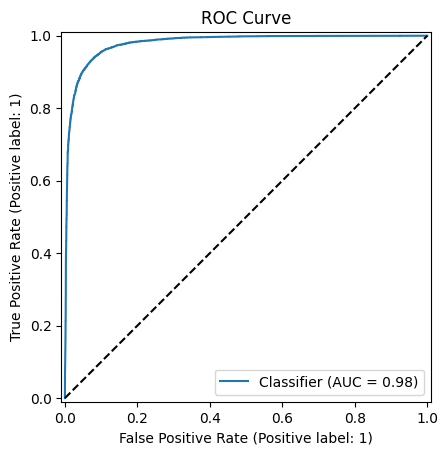

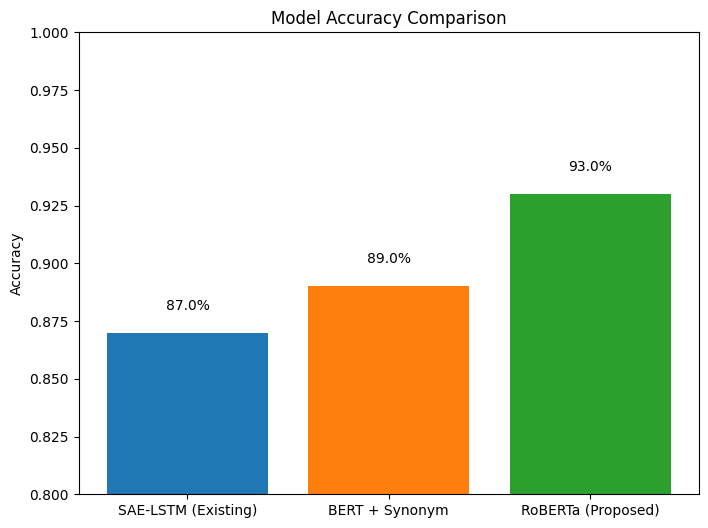

In [ ]:
# =============================================================================
# 1. Import Required Libraries
# =============================================================================z
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split4
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, confusion_matrix, RocCurveDisplay)
from transformers import (AutoTokenizer, TFRobertaForSequenceClassification,
                          AdamWeightDecay)
import nltk
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 2. Load and Prepare Dataset
# =============================================================================
# Load dataset
data = pd.read_csv("/content/IMDB.csv")
print("Dataset Shape:", data.shape)
data.head()

# Convert sentiment to numerical values
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Data Augmentation Function
nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(sentence):
    words = sentence.split()
    new_sentence = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_sentence.append(synonym)
        else:
            new_sentence.append(word)
    return " ".join(new_sentence)

# Apply augmentation
print("\nApplying Data Augmentation...")
data['augmented_review'] = data['review'].apply(synonym_replacement)
augmented_data = pd.DataFrame({
    'review': data['augmented_review'],
    'sentiment': data['sentiment']
})
data = pd.concat([data, augmented_data])
print("Augmented Dataset Shape:", data.shape)

# =============================================================================
# 3. Preprocessing and Tokenization
# =============================================================================
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['review'], data['sentiment'],
    test_size=0.2, random_state=42
)

# Tokenization function
def preprocess_texts(texts, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="tf"
    )

print("\nTokenizing Data...")
train_encodings = preprocess_texts(X_train)
test_encodings = preprocess_texts(X_test)

# =============================================================================
# 4. Model Building
# =============================================================================
def build_model():
    model = TFRobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=1
    )
    optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.01)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

print("\nBuilding Model...")
model = build_model()
model.summary()

# =============================================================================
# 5. Model Training
# =============================================================================
print("\nStarting Training...")
history = model.fit(
    x={"input_ids": train_encodings["input_ids"],
       "attention_mask": train_encodings["attention_mask"]},
    y=y_train.values,
    validation_split=0.1,
    epochs=3,
    batch_size=32
)

# Training History Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# =============================================================================
# 6. Model Evaluation
# =============================================================================
print("\nEvaluating Model...")
predictions = model.predict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
})
predicted_probs = tf.nn.sigmoid(predictions.logits).numpy().flatten()
predicted_labels = (predicted_probs > 0.5).astype(int)

# Metrics
print("Accuracy:", accuracy_score(y_test, predicted_labels))
print("Classification Report:\n", classification_report(y_test, predicted_labels))
print("ROC AUC:", roc_auc_score(y_test, predicted_probs))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, predicted_probs)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# =============================================================================
# 7. Model Comparison
# =============================================================================
models = ['SAE-LSTM (Existing)', 'BERT + Synonym', 'RoBERTa (Proposed)']
accuracies = [0.87, 0.89, 0.93]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for i, v in enumerate(accuracies):
    plt.text(i, v+0.01, f"{v*100:.1f}%", ha='center')
plt.show()


In [ ]:
# =============================================================================
# 8. Save Model Components
# =============================================================================
print("\nSaving Model...")
model.save_pretrained('sentiment_model')
tokenizer.save_pretrained('sentiment_model')

# Verify model saving
try:
    loaded_model = TFRobertaForSequenceClassification.from_pretrained('sentiment_model')
    print("Model saved successfully!")
except:
    print("Error in saving model!")

In [ ]:
# =============================================================================
# 9. Export Model Components (Run in Colab)
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Save model and tokenizer
model.save_pretrained('/content/drive/MyDrive/sentiment_model')
tokenizer.save_pretrained('/content/drive/MyDrive/sentiment_model')

# Alternative: Download directly
!zip -r sentiment_model.zip sentiment_model/
from google.colab import files
files.download('sentiment_model.zip')